**OBJETIVO**. Clasificar texto procedente de historias clínicas electrónicas en código CIE-10 usando ChatGPT.

El CIE-10 (Clasificación Internacional de Enfermedades, décima edición) es un sistema de clasificación médica utilizado para codificar y clasificar enfermedades y otros problemas de salud. ASigna códigos alfanuméricos a una amplia variedad de enfermedades, trastornos, lesiones, causas externas de morbilidad y otros problemas de salud. Cada código está compuesto por entre 3 y 7 caracteres, que proporcionan información detallada sobre la condición médica o el evento en cuestión.

Tendremos un **conjunto de train** con historias clínicas electrónicas y varias etiquetas CIE-10 asociadas, así como un **conjunto de test** *no etiquetado*. El resultado de la predicción solo podrá ser visto al subirlo a una página web que nos brindaron los profesores, disponiendo de un máximo de **3 intentos**. Para ello, previamente deberemos guardar las predicciones sobre este conjunto en un **dataframe** que exportaremos a formato `.csv`.

Será necesario que demos también nuestro historial de chat en ChatGPT (uno por integrante) en lo relacionado con el proyecto, por lo que será necesario dar el enlace directo de este (al final del notebook está).

Por último, se deberá escribir un artículo científico con las secciones siguientes: 1. Introducción, 2. Materiales y métodos, 3. Resultados, 4. Discusión y 5. Conclusiones.

# GPTChallenge: diagnóstico a partir de HCE

**Grupo 2: GPTSovereigns** 👨‍💻

Integrantes: 
- Martínez Leal, Jesús
- Ortega Mediavilla, Samuel
- Vicente Martínez, Pablo

Aunque el dataset de **train** tiene casi 1000 códigos, tomaremos solo las historias clínicas con los **10 códigos más frecuentes**.

==============================================================================================================================================================================================================================================================================================

Vamos a trabajar con el corpus **CodEsp** (textos de historial clínico etiquetados con sus códigos CIE-10 Diagnóstico). 

## Carga de librerías y definición de funciones 

In [28]:
import pandas as pd # used for data manipulation
import os, re, spacy # used for text processing, regular expressions, and nlp purposes
import numpy as np # used for numerical operations
import matplotlib.pyplot as plt # used for plotting
from sklearn.preprocessing import MultiLabelBinarizer # used for encoding labels
from sklearn.feature_extraction.text import CountVectorizer # used for text vectorization
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier # used for classification
from sklearn.neighbors import KNeighborsClassifier # used for classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier # used for classification, ensemble methods
from sklearn.multioutput import MultiOutputClassifier # used for multi-label classification
from sklearn.model_selection import train_test_split, GridSearchCV # used for splitting data, hyperparameter tuning
from sklearn.metrics import classification_report, make_scorer, f1_score # used for evaluation
from sklearn.metrics.pairwise import cosine_similarity # used for similarity calculation
from sklearn.metrics import roc_curve, auc # used for roc curve calculation
import lightgbm as lgb # used for classification
from scipy.sparse import vstack # used for stacking sparse matrices

pd.options.display.max_colwidth = None 

In [3]:
seed = 3 # semilla uwu

In [4]:
def normalizeDoc(nlp, doc, nMinCharacters = 0):
    """
    Normaliza un texto eliminando palabras por debajo del mínimo de caracteres, stop words y números.
    Para ello, tokeniza empleando un modelo de Spacy.
    """
    # Separar en tokens
    tokens = nlp(doc)
    # Filtrar tokens
    filtered_tokens = [t.lower_ for t in tokens if (len(t.text) >= nMinCharacters) and not t.is_punct and not re.match('[0-9]+', t.text)] # Filtrar palabras por longitud y quitar números y signos de puntuación
    # Recombinamos los tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

def findMostSimilar(similarityDf: pd.DataFrame, data: pd.DataFrame, nMostSimilars: int = 1):
    """
    Encuentra la etiqueta de los documentos más similares.
    """
    # Crear df de resultados
    results = pd.DataFrame(index = similarityDf.index, columns = ['archivoMostSimilar', 'similarity', 'codigosPred'])

    for index, row in similarityDf.iterrows():
        
        # Buscar la máxima similitud
        mostSimilar = row.nlargest(nMostSimilars)
        
        results.loc[index, 'archivoMostSimilar'] = mostSimilar.index.values
        if nMostSimilars == 1:
            results.loc[index, 'similarity'] = mostSimilar.values[0]
        else:
            results.loc[index, 'similarity'] = row[mostSimilar.index]

    # Coger las etiquetas
    if nMostSimilars == 1:
        results['codigosPred'] = data.loc[np.squeeze(np.vstack(results['archivoMostSimilar'].values)), 'codigos'].values
    else:
        pass
    return results

def checkAccuracy(pred: pd.DataFrame, data: pd.DataFrame):
    pred['codigos'] = data.loc[pred.index, 'codigos']

    pred['guess'] = pred.apply(
        lambda row: len(set(row['codigosPred']).intersection(row['codigos'])) / len(row['codigosPred']),
        axis = 1)
    return pred

In [34]:
def plot_roc_curve(y_pred_proba, y_train_test, title, save_filename):
    """
    - Calcula la curva ROC para cada clase individualmente y la curva ROC promedio.
    - Grafica las curvas ROC individuales por clase y la curva ROC promedio.
    - Guarda la figura en la carpeta 'results/images'.
    """
    # Transponer y_pred_proba
    y_pred_proba_np = np.array(y_pred_proba)
    y_pred_proba_np_transpose = np.transpose(y_pred_proba_np, (1, 0, 2))

    # Inicializar listas para almacenar los valores de fpr y tpr para cada clase
    fpr_list = []
    tpr_list = []
    roc_auc_list = []

    # Calculamos la curva ROC para cada clase individualmente
    for i in range(y_pred_proba_np_transpose.shape[1]):
        fpr, tpr, _ = roc_curve(y_train_test[:, i], y_pred_proba_np_transpose[:, i, 1])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(auc(fpr, tpr))

    # Calculamos la curva ROC promedio
    mean_fpr = np.unique(np.concatenate([fpr_list[i] for i in range(len(fpr_list))]))
    mean_tpr = np.zeros_like(mean_fpr)

    for i in range(len(fpr_list)):
        mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])

    mean_tpr /= len(fpr_list)
    roc_auc = auc(mean_fpr, mean_tpr)

    # Graficamos las curvas ROC individuales por clase
    plt.figure(figsize=(10, 6))
    for i in range(len(fpr_list)):
        plt.plot(fpr_list[i], tpr_list[i], label=f'ROC curve (area = {roc_auc_list[i]:.2f}) for class {i+1}', alpha=0.5)

    # Graficamos la curva ROC promedio
    plt.plot(mean_fpr, mean_tpr, color='black', linewidth=2.5, label=f'Average ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')

    # Guardar la figura
    if not os.path.exists('./results/images'):
        os.makedirs('./results/images')
    plt.savefig(f'./results/images/{save_filename}.png', bbox_inches='tight')
    plt.show()

## Lectura y preprocesamiento de los datos

### Conjunto de train

In [5]:
#los códigos están en un TSV con un código por línea
train_diag = pd.read_csv("data/train/train.tsv", sep="\t", header=None, names=["archivo", "codigo"])
train_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316 entries, 0 to 8315
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  8316 non-null   object
 1   codigo   8316 non-null   object
dtypes: object(2)
memory usage: 130.1+ KB


In [6]:
#cogemos la categoría superior de cada código y las agrupamos
train_diag['cat'] = train_diag['codigo'].str.extract(r'(\w\d\d)')
print(train_diag['cat'].value_counts())
train_diag['cat'].nunique()

cat
r52    163
r10    163
r59    160
r69    150
r50    144
      ... 
c31      1
d62      1
s53      1
s34      1
n81      1
Name: count, Length: 918, dtype: int64


918

In [7]:
categories=train_diag['cat'].value_counts()[:10] # cogemos las 10 categorías más comunes
top_categorias = categories.index.to_list()
print(top_categorias)

['r52', 'r10', 'r59', 'r69', 'r50', 'r60', 'i10', 'r11', 'n28', 'd49']


In [8]:
#seleccionamos sólo las etiquetas de este subconjunto
train_diag = train_diag[np.isin(train_diag['cat'], top_categorias)]

In [9]:
#cargamos los dos conjuntos de train
path = 'data/train/text_files/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()
    #buscamos códigos
    file = f[:-4]
    codigos = train_diag.query('archivo==@file')['cat'].to_list()
    codigos = list(set(codigos))
    if codigos:
        corpus.append({
            'archivo': file,
            'texto': texto,
            'codigos': codigos
        })
    
df_train = pd.DataFrame(corpus).set_index('archivo')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, S0004-06142005000700014-1 to S2340-98942015000100005-1
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   texto    562 non-null    object
 1   codigos  562 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


In [10]:
df_train.sample(1)

,texto,codigos
archivo,,
S1130-63432016000200009-1,"Varón de 27 años de edad que acude a una consulta de Medicina Interna derivado por su médico de atención primaria por: astenia de tres meses de evolución, mareo inespecífico y epigastralgia intermitente de intensidad moderada. Como antecedentes personales relevantes presenta: rinoconjuntivitis alérgica. Su tratamiento habitual consta de ebastina 10 mg en una única toma diaria durante el periodo de alergia estacional.\nA la exploración destaca una marcada palidez de piel y mucosas. En la analítica destaca hemoglobina de 6,5 g/ dL (13-18 g/dL), volumen corpuscular medio de 125 fl (80-100 fl), leucocitos de 6,000/mL (4,000-10,500/mL), plaquetas de 280.000/mm3 (150.000-400,000/mm3, bilirrubina total de 1,35 mg/dL (0,3-1,2 mg/dL), aspartato aminotransferasa (AST) de 140 UI/L (4-50 UI/L), alanina aminotransferasa (ALT) de 410 UI/L (5-47 UI UI/L), lactato deshidrogenasa (LDH de 4.186 UI/L (140-240 UI/L). Ante esta analítica se solicita un frotis sanguíneo que muestra anisocitosis de tendencia macrocítica, hipersegmentación de neutrófilos y algunos dacriocitos. El estudio del hierro y los niveles de ácido fólico eran normales, con unos niveles de vitamina B12 sérica de 62 pg/mL (180880 pg/mL y homocisteína de 32 μmol (4-15 μmol/L). Los niveles de gastrina se encuentran claramente elevados 539 pg/mL (normal < 100 pg/mL). Se inicia tratamiento con inyecciones intramusculares de 1.000 μg/ día de vitamina B12 durante los 7 días, posteriormente semanales durante un mes y terapia de mantenimiento con una inyeción al mes.\nEl hemograma se normaliza en la cuarta semana de tratamiento.\n\n",[r10]


### Conjunto de test

Repetimos algo similar, pero ahora no tenemos las etiquetas disponibles.

In [11]:
#los códigos están en un TSV con un código por línea
test_diag = pd.read_csv("data/test/test.tsv", sep = "\t", header = None, names = ["archivo"])
test_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  192 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [12]:
path = 'data/test/text_files/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    file = os.path.splitext(f)[0]
    if file in test_diag['archivo'].values:
        with open(os.path.join(path, f), encoding="utf8") as text:
            texto = text.read()
            corpus.append({
                'archivo': file,
                'texto': texto
            })
    
df_test = pd.DataFrame(corpus).set_index('archivo')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, S0004-06142005000500011-1 to S2254-28842014000300010-1
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   192 non-null    object
dtypes: object(1)
memory usage: 3.0+ KB


In [13]:
df_test.sample(1)

,texto
archivo,
S0365-66912004001100011-1,"Mujer de 71 años, con antecedentes de diabetes mellitus tipo 2, remitida por ulceración corneal de probable etiología herpética del ojo izquierdo de dos meses de evolución, acompañada de dolor ocular leve. La paciente refirió haber sufrido inflamación ocular asociada a dermatitis frontal, compatible con herpes zoster, dos años antes. En la primera visita presentaba una agudeza visual de 0,4 en el ojo derecho y cuenta dedos a 1 metro en el ojo izquierdo, catarata leve bilateral, tonometría normal y fondo de ojo sin alteraciones significativas en ambos ojos. En el ojo izquierdo se observó una ulceración corneal superficial y central, con infiltrados bien delimitados en los bordes, asociada a reacción inflamatoria en cámara anterior (tyndall celular 2+).\nSe realizó una toma de muestras para cultivo microbiológico mediante raspado corneal, y se prescribió itraconazol oral 200 mg/24h asociado a tratamiento tópico con anfotericina B 0,15%, cefazolina 50 mg/ml y tobramicina 15 mg/ml, basado en la principal sospecha de queratitis fúngica. El cultivo mostró crecimiento de Candida albicans, razón por la que se mantuvo el mismo tratamiento. La queratitis empeoró rápidamente hasta la perforación corneal en el curso de 6 días, precedida por un aumento importante del dolor, hiperemia grave, extensión del defecto epitelial corneal, aparición de infiltración estromal densa (necrosis), hipopion e hipertensión ocular. Se realizó de urgencia un trasplante de membrana amniótica (triple capa), precedido intraoperatoriamente por una nueva toma de muestras mediante raspado corneal para su cultivo microbiológico. El resultado de este cultivo (aerobio y anaerobio) fue negativo para bacterias.\nComo tratamiento médico se inició la administración de voriconazol vía intravenosa (200 mg/24 h) asociado a aceclofenaco oral, lágrimas artificiales sin conservantes y brimonidina tópica. Tras 10 días se sustituyó la administración intravenosa de voriconazol por la vía oral (200 mg/24 h) y se mantuvo durante 6 semanas. El cuadro clínico respondió favorablemente al tratamiento, desapareciendo progresivamente los signos inflamatorios durante los primeros 15 días. La paciente sólo presentó visión borrosa al inicio del tratamiento y un aumento leve de LDH en sangre, sin otros efectos secundarios. Se observó una buena integración del injerto de membrana amniótica, aunque posteriormente precisó la realización de una queratoplastia penetrante debido a la cicatrización corneal residual (leucoma adherente).\n"


### Binarizar las etiquetas

In [14]:
# para entrenar un clasificador multi-etiqueta generamos una matriz binaria de las etiquetas
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

#Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


## Procesamiento del lenguaje natural

En esta sección se llevará a cabo el procesamiento de los textos provenientes de las historias clínicas usando técnicas de NLP.

Con la librería de spacy cargamos el modelo `es_core_news_lg` de Spacy. El sufijo *lg* indica que es un modelo de tamaño grande.

In [15]:
# python -m spacy download es_core_news_lg
nlp = spacy.load("es_core_news_lg")

### BoW

El enfoque Bag of Words (BoW) es una técnica simple pero efectiva utilizada en el procesamiento de lenguaje natural para representar documentos de texto como vectores numéricos. La idea detrás de BoW es tratar cada documento como un "saco" de palabras, sin tener en cuenta el orden en que aparecen las palabras en el texto.

Obtenemos resultados ligeramente mejores sin realizar un preprocesamiento con la función `normalizeDoc()` previamente a la aplicación del *Bag of Words*. La adición de *n-grams* empeora los resultados de los modelos.

In [16]:
# x_trainText = [normalizeDoc(nlp, doc) for doc in df_train['texto'].values]
x_trainText = df_train['texto'].values
x_testText = df_test['texto'].values

vectorizer = CountVectorizer() # para el bag of words, de sklearn
x_trainArray = vectorizer.fit_transform(x_trainText) # matriz tipo sparse
x_testArray = vectorizer.transform(x_testText)

Las matrices sparse `x_trainArray` y `x_testArray` contienen los recuentos de palabras del BoW para train y test.

## Modelos

Empezamos dividiendo nuestro conjunto de training en dos subconjuntos, que nos permitan distinguir entre lo que sería el conjunto de training y el de testing. Estrictamente, es un conjunto de validación.

In [17]:
x_train, x_test, y_train_train, y_train_test = train_test_split(x_trainArray, y_train, test_size = 0.1, random_state = seed)

### Nuestro mejor modelo: MultiOutput con GradientBoosting

Se aplica un modelo de clasificación conocido como **Gradient Boosting Classifier**, el cual es una técnica de ensemble learning que combina múltiples modelos de árboles de decisión débiles para construir un modelo más robusto y preciso. Este modelo se caracteriza por ajustar secuencialmente nuevos árboles de decisión a los residuos del modelo anterior, lo que permite mejorar gradualmente la predicción. En este caso particular, se utilizará una variante del Gradient Boosting Classifier con una función de pérdida exponencial y se configurarán varios hiperparámetros, como el número de estimadores, la profundidad máxima del árbol y el número mínimo de muestras requeridas para dividir un nodo.

Con el **MultiOutputClassifier** tendremos un clasificador por target. Esta es una estrategia simple para extender clasificadores que de manera nativa no soportan una clasificación multi-output.

 Una vez que el modelo esté entrenado, se evaluará su rendimiento utilizando métricas como la precisión, el recall y el puntaje F1 a través de un informe de clasificación.

Información `GradientBoostingClassifier()`: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html.

Información `MultiOutputClassifier()`: https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html

In [18]:
print(x_train.shape)

(505, 17317)


In [23]:
base_classifier = GradientBoostingClassifier(loss = 'exponential', n_estimators = 50, max_depth = 5, min_samples_split = 5, random_state = seed)
model = MultiOutputClassifier(base_classifier, n_jobs = 4)
model.fit(x_train, y_train_train)
y_pred = model.predict(x_test)

report = classification_report(y_train_test, y_pred, zero_division = 0) # zero_division = 0 para evitar warnings
print(report)

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       1.00      1.00      1.00        16
           2       1.00      0.75      0.86         8
           3       0.80      0.57      0.67        14
           4       1.00      1.00      1.00         8
           5       1.00      0.93      0.97        15
           6       1.00      0.31      0.47        13
           7       1.00      0.92      0.96        12
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00        17

   micro avg       0.96      0.80      0.87       124
   macro avg       0.96      0.80      0.85       124
weighted avg       0.96      0.80      0.85       124
 samples avg       0.92      0.82      0.85       124



Vemos que obtenemos un f1-score de 0.85 en la versión `weighted` para el conjunto de validación que habíamos previamente establecido.

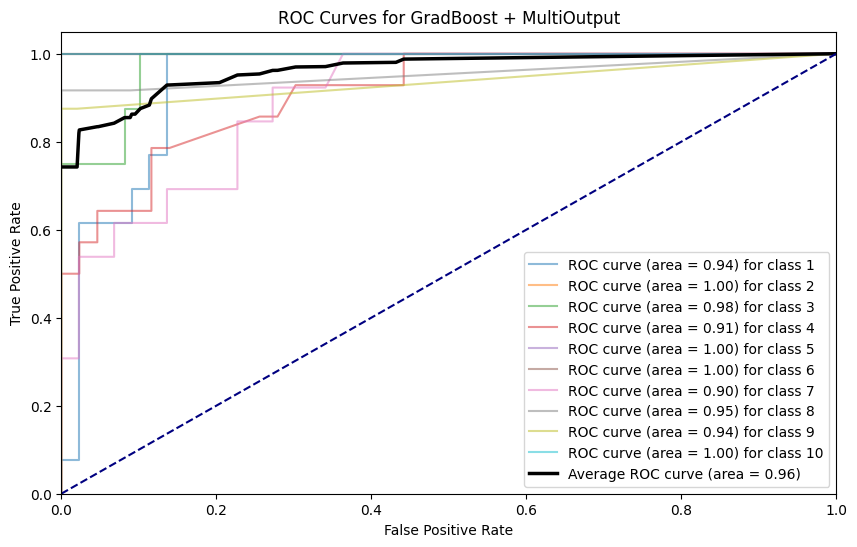

In [37]:
y_pred_proba = model.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for GradBoost + MultiOutput', 'gradboost_multioutput')

### Coseno similitud (*manual*)

En esta subsección se usa una técnica de similitud coseno manual para encontrar los documentos más similares dentro del conjunto de entrenamiento en relación con los documentos del conjunto de prueba.

Hacemos primeramente una división para los textos también, al igual que hicimos anteriormente con las matrices sparse (mantenemos mismo random_state).

In [19]:
xTag = df_train.index.values 

x_trainT, x_testT, xTag_train, xTag_test = train_test_split(x_trainText, xTag, random_state = seed)

In [20]:
vectorizer = CountVectorizer()
x_trainVec = vectorizer.fit_transform(x_trainT)
x_trainVecDf = pd.DataFrame(x_trainVec.toarray(), columns = vectorizer.get_feature_names_out(), index = xTag_train)

x_testVec = vectorizer.transform(x_testT)
x_testVecDf = pd.DataFrame(x_testVec.toarray(), columns = vectorizer.get_feature_names_out(), index = xTag_test)

similarity = cosine_similarity(x_testVecDf, x_trainVecDf)
similarityDf = pd.DataFrame(similarity, index = x_testVecDf.index, columns = x_trainVecDf.index)

In [21]:
mostSimilarDf = findMostSimilar(similarityDf, df_train)

mostSimilarDf.head()

,archivoMostSimilar,similarity,codigosPred
S0210-48062010000100019-4,S0210-48062009000900017-1,0.723986,[d49]
S1134-80462015000200005-1,S0376-78922016000200012-1,0.877009,"[r69, d49, i10]"
S1139-76322009000400007-1,S1698-69462006000400005-1,0.829529,"[n28, d49]"
S0376-78922014000100013-1,S0376-78922016000200012-1,0.878946,"[r69, d49, i10]"
S1130-01082007001100012-1,S0212-16112010000100017-1,0.690295,[r60]


In [22]:
mostSimilarDf = checkAccuracy(mostSimilarDf, df_train)
print(f"Al menos 1 coincidencia: {(mostSimilarDf['guess'] != 0).sum() / mostSimilarDf.shape[0]}")
print(f"Accuracy media: {mostSimilarDf['guess'].mean()}")

Al menos 1 coincidencia: 0.4397163120567376
Accuracy media: 0.2504728132387707


### Otros modelos de clasificación multietiqueta

#### Random Forest

El modelo de Random Forest es una técnica de aprendizaje automático que se basa en la construcción de múltiples árboles de decisión durante el proceso de entrenamiento y combina sus predicciones para obtener una predicción final. Cada árbol en el bosque se entrena de forma independiente utilizando un subconjunto aleatorio de las características y las muestras del conjunto de entrenamiento, lo que fomenta la diversidad entre los árboles y ayuda a reducir el sobreajuste.

Una de las características clave del modelo de Random Forest es su capacidad para manejar problemas de múltiples salidas o multioutput.

Hemos comprobado que aumentar el número de estimadores, `n_estimators` disminuye drásticamente los resultados. Es por eso que tenemos un número bajo. 
Por otra parte, el criterio `criterion` no parece afectar de manera significativa a los resultados.

In [38]:
multi_target_classifier = RandomForestClassifier(n_estimators = 3, criterion = 'gini', n_jobs = 4, random_state = seed)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.25      0.08      0.12        13
           1       0.86      0.38      0.52        16
           2       0.50      0.12      0.20         8
           3       0.50      0.29      0.36        14
           4       0.75      0.38      0.50         8
           5       0.50      0.33      0.40        15
           6       0.36      0.31      0.33        13
           7       0.60      0.25      0.35        12
           8       0.50      0.12      0.20         8
           9       0.33      0.12      0.17        17

   micro avg       0.51      0.24      0.33       124
   macro avg       0.52      0.24      0.32       124
weighted avg       0.51      0.24      0.32       124
 samples avg       0.36      0.26      0.28       124



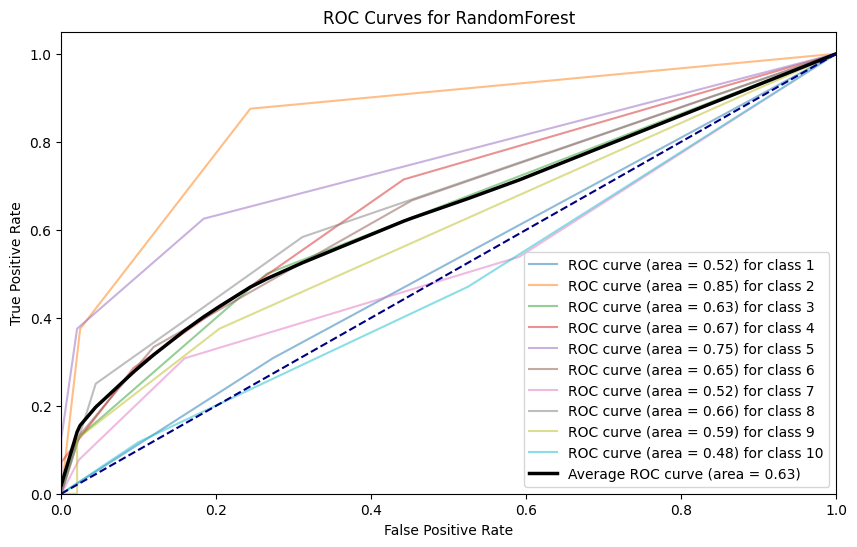

In [39]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for RandomForest', 'randomforest')

La semilla `random_state` depende enormemente de los resultados que se obtienen.

#### Multi Layer Perceptron

El MLPClassifier, que representa el Perceptrón Multicapa (Multilayer Perceptron) en la biblioteca scikit-learn, es una poderosa herramienta de aprendizaje supervisado utilizada para la clasificación. Basado en redes neuronales artificiales, el MLPClassifier es conocido por su capacidad para modelar relaciones complejas entre las características de entrada y las etiquetas de salida en conjuntos de datos.

Al aprovechar una arquitectura de red neuronal con múltiples capas de nodos interconectados, el MLPClassifier puede aprender patrones no lineales en los datos.

Más información: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Usamos el optimizador `Adam` ya que generalmente es el que mejores resultados ofrece. Las redes neuronales por construcción también van a admitir fácilmente una clasificación multi-output. `MLPClassifier` gestiona eso.

In [197]:
multi_target_classifier = MLPClassifier(activation = 'relu', solver = 'adam', max_iter = 1000, random_state = seed)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.50      0.06      0.11        16
           2       1.00      0.50      0.67         8
           3       1.00      0.21      0.35        14
           4       0.50      0.12      0.20         8
           5       0.80      0.27      0.40        15
           6       0.50      0.15      0.24        13
           7       1.00      0.33      0.50        12
           8       0.00      0.00      0.00         8
           9       1.00      0.12      0.21        17

   micro avg       0.79      0.18      0.29       124
   macro avg       0.73      0.19      0.28       124
weighted avg       0.76      0.18      0.28       124
 samples avg       0.30      0.18      0.21       124



c:\Users\jesus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for MLP', 'mlp')

#### MultiOutput

Se muestran a continuación otros resultados con clasificadores a los que se les añade la funcionalidad que proporciona `MultiOutputClassifier`.

Con este se hace un ajuste de un clasificador por cada *target*. 

##### Regression Classifiers

La clase `LogisticRegression()` en scikit-learn es una implementación del algoritmo de regresión logística, también conocido como logit o MaxEnt, que se utiliza principalmente para problemas de clasificación binaria y multiclase. Este algoritmo modela la relación entre una variable dependiente categórica y una o más variables independientes mediante el uso de la función logística para predecir la probabilidad de que una observación pertenezca a una determinada categoría.

La clase ofrece una variedad de opciones para personalizar el modelo, como la especificación del tipo de penalización, el ajuste de la regularización, la elección del solver para la optimización, entre otros.

Más información: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [21]:
base_classifier = LogisticRegression(penalty = 'l2', solver = 'newton-cg', max_iter = 1000,
                                     multi_class = 'multinomial', random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.23      0.35        13
           1       1.00      0.25      0.40        16
           2       0.64      0.88      0.74         8
           3       0.71      0.36      0.48        14
           4       0.38      0.38      0.38         8
           5       0.67      0.27      0.38        15
           6       0.43      0.23      0.30        13
           7       0.75      0.50      0.60        12
           8       0.00      0.00      0.00         8
           9       0.91      0.59      0.71        17

   micro avg       0.67      0.36      0.47       124
   macro avg       0.62      0.37      0.43       124
weighted avg       0.68      0.36      0.45       124
 samples avg       0.51      0.33      0.39       124



In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for LogReg + MultiOutput', 'logreg_multioutput')

In [145]:
base_classifier = PassiveAggressiveClassifier(random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.31      0.40        13
           1       0.80      0.50      0.62        16
           2       0.64      0.88      0.74         8
           3       0.70      0.50      0.58        14
           4       0.29      0.25      0.27         8
           5       0.75      0.40      0.52        15
           6       0.56      0.38      0.45        13
           7       0.78      0.58      0.67        12
           8       0.50      0.12      0.20         8
           9       0.89      0.47      0.62        17

   micro avg       0.67      0.44      0.53       124
   macro avg       0.65      0.44      0.51       124
weighted avg       0.68      0.44      0.52       124
 samples avg       0.58      0.46      0.48       124



In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for PassiveAggressive + MultiOutput', 'passiveaggressive_multioutput')

In [146]:
base_classifier = SGDClassifier(loss = 'squared_hinge', penalty = 'elasticnet', random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.80      0.25      0.38        16
           2       0.47      0.88      0.61         8
           3       0.56      0.36      0.43        14
           4       0.14      0.12      0.13         8
           5       0.86      0.40      0.55        15
           6       0.42      0.38      0.40        13
           7       0.60      0.75      0.67        12
           8       0.40      0.25      0.31         8
           9       0.75      0.53      0.62        17

   micro avg       0.54      0.42      0.47       124
   macro avg       0.54      0.42      0.45       124
weighted avg       0.59      0.42      0.46       124
 samples avg       0.51      0.44      0.44       124



In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for SGD + MultiOutput', 'sgd_multioutput')

##### Random Forest

Introducimos ahora para nuestro modelo de `RandomForestClassifier` un acople con `MultiOutputClassifier` para tener un enfoque de uno en uno para cada *target*.

In [26]:
base_classifier = RandomForestClassifier(n_estimators = 3, random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.86      0.75      0.80        16
           2       0.50      0.38      0.43         8
           3       0.62      0.36      0.45        14
           4       0.50      0.25      0.33         8
           5       1.00      0.33      0.50        15
           6       0.42      0.38      0.40        13
           7       0.64      0.75      0.69        12
           8       1.00      0.12      0.22         8
           9       0.71      0.29      0.42        17

   micro avg       0.66      0.41      0.51       124
   macro avg       0.69      0.39      0.47       124
weighted avg       0.70      0.41      0.49       124
 samples avg       0.46      0.34      0.37       124



Vemos que obtenemos mejores resultados que en el caso anterior.

In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for RandomForest + MultiOutput', 'randomforest_multioutput')

##### K-Neighbors

`KNeighborsClassifier` es un clasificador de vecinos más cercanos implementado en scikit-learn que se utiliza para problemas de clasificación supervisada. Este algoritmo clasifica las instancias de datos basándose en la similitud con los ejemplos de entrenamiento más cercanos en el espacio de características. Específicamente, asigna una etiqueta a una nueva instancia según la mayoría de votos de sus k vecinos más cercanos, donde k es un parámetro definido por el usuario. `KNeighborsClassifier` es fácil de entender e implementar, y es especialmente útil para conjuntos de datos pequeños o medianos donde la relación entre las características y las etiquetas es no lineal. Antes de utilizar este clasificador, es importante ajustar adecuadamente el valor de k y comprender cómo afecta al rendimiento del modelo en diferentes conjuntos de datos.

Más información: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Los mejores resultados apreciados se obtienen con `n_neighbors = 3`.

In [35]:
base_classifier = KNeighborsClassifier(n_neighbors = 3)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.15      0.25        13
           1       0.38      0.19      0.25        16
           2       0.00      0.00      0.00         8
           3       0.75      0.21      0.33        14
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00        15
           6       0.44      0.31      0.36        13
           7       0.40      0.33      0.36        12
           8       0.50      0.38      0.43         8
           9       0.50      0.29      0.37        17

   micro avg       0.41      0.19      0.26       124
   macro avg       0.36      0.19      0.24       124
weighted avg       0.39      0.19      0.25       124
 samples avg       0.32      0.20      0.23       124



De todas formas, los resultados no son buenos.

In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for KNN + MultiOutput', 'knn_multioutput')

##### Gradient Boosting: Grid Search (mejor modelo)

`GridSearchCV`, que significa Validación Cruzada con Búsqueda de Cuadrícula, es una técnica de búsqueda de hiperparámetros exhaustiva que se utiliza para encontrar la combinación óptima de hiperparámetros para un modelo de aprendizaje automático. Funciona evaluando sistemáticamente todas las combinaciones posibles de valores de hiperparámetros especificados en una cuadrícula predefinida. Para cada combinación de hiperparámetros, `GridSearchCV` utiliza la validación cruzada para evaluar el rendimiento del modelo en múltiples divisiones del conjunto de datos de entrenamiento, lo que ayuda a mitigar el riesgo de sobreajuste. Al finalizar la búsqueda, devuelve la combinación de hiperparámetros que produce el mejor rendimiento según una métrica especificada, como precisión, puntuación F1 o alguna otra medida de rendimiento.

`GridSearchCV` es una herramienta poderosa para optimizar los modelos de aprendizaje automático, ya que automatiza el proceso de ajuste de hiperparámetros y ayuda a encontrar la configuración que maximiza el rendimiento del modelo en datos no vistos.

Más información: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [150]:
base_classifier = GradientBoostingClassifier(loss = 'exponential', random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)

param_grid = {
    'estimator__n_estimators': [40, 50, 60],
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_split': [2, 5, 10]
}

f1_scorer = make_scorer(f1_score, average = 'weighted')

grid_search = GridSearchCV(multi_target_classifier, param_grid, cv = 5, scoring = f1_scorer, n_jobs = 4, verbose = 1)
grid_search.fit(x_train, y_train_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_estimator = grid_search.best_estimator_
best_estimator.fit(x_train, y_train_train)

y_pred = best_estimator.predict(x_test)

report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'estimator__max_depth': 7, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        13
           1       1.00      1.00      1.00        16
           2       0.60      0.75      0.67         8
           3       0.89      0.57      0.70        14
           4       1.00      1.00      1.00         8
           5       1.00      0.93      0.97        15
           6       0.80      0.31      0.44        13
           7       1.00      0.92      0.96        12
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00        17

   micro avg       0.90      0.77      0.83       124
   macro avg       0.87      0.77      0.81       124
weighted avg       0.89      0.77      0.81       124
 samples avg       0.88      0.80      0.81       124



Intentamos mejorar el modelo añadiendo un `AdaBoostClassifier` para mejorar el *fitting* del estimador.

`AdaBoostClassifier` es un algoritmo de aprendizaje automático que se utiliza comúnmente para la clasificación. Es un tipo de algoritmo de conjunto que combina múltiples modelos de aprendizaje débiles para crear un modelo fuerte. El principio básico detrás de AdaBoost es entrenar iterativamente una secuencia de clasificadores débiles, donde cada clasificador se enfoca en las instancias que los clasificadores anteriores clasificaron incorrectamente. En cada iteración, se da más peso a las instancias clasificadas incorrectamente para que el próximo clasificador se centre en corregir esos errores. 

Al final del proceso, los clasificadores débiles se combinan mediante votación ponderada para formar un clasificador fuerte. AdaBoost es efectivo en una variedad de problemas de clasificación y es especialmente útil cuando se utilizan clasificadores simples como base, como árboles de decisión con poca profundidad.

Más información: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [152]:
estimator = GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse', n_estimators = 50, max_depth = 5, min_samples_split = 5, random_state = seed)
base_classifier = AdaBoostClassifier(estimator = estimator, n_estimators = 100, random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train, y_train_train)
y_pred = multi_target_classifier.predict(x_test)
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.46      0.60        13
           1       1.00      1.00      1.00        16
           2       1.00      0.75      0.86         8
           3       0.80      0.57      0.67        14
           4       1.00      1.00      1.00         8
           5       1.00      0.93      0.97        15
           6       1.00      0.38      0.56        13
           7       1.00      0.92      0.96        12
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00        17

   micro avg       0.96      0.79      0.87       124
   macro avg       0.95      0.79      0.85       124
weighted avg       0.95      0.79      0.85       124
 samples avg       0.88      0.79      0.82       124



Los resultados mejoraron ligeramente.

In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test)
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for GradBoost + AdaBoost + MultiOutput', 'gradboost_adaboost_multioutput')

##### Light Gradient-Boosting

El Light Gradient Boosting Classifier (LightGBM) es una poderosa implementación de algoritmo de aumento de gradiente que se destaca por su eficiencia y rendimiento en conjuntos de datos grandes. Utiliza una estrategia de construcción de árboles en hojas, lo que significa que se construyen los nodos hoja primero y luego se dividen hacia atrás. Esto reduce significativamente el consumo de memoria y acelera el tiempo de entrenamiento. LightGBM también utiliza una técnica de muestreo por gradiente para seleccionar los mejores nodos hoja, lo que mejora la precisión del modelo y lo hace altamente escalable. Además, proporciona una variedad de parámetros para la personalización del modelo y es ampliamente utilizado en problemas de clasificación y regresión en la práctica de aprendizaje automático.

Más información: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [38]:
base_classifier = lgb.LGBMClassifier(boosting_type = 'dart', n_estimators = 50, objective = 'binary', random_state = seed)
multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs = 4)
multi_target_classifier.fit(x_train.astype(np.float32), y_train_train)
y_pred = multi_target_classifier.predict(x_test.astype(np.float32))
report = classification_report(y_train_test, y_pred, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.92      0.75      0.83        16
           2       0.71      0.62      0.67         8
           3       0.88      0.50      0.64        14
           4       1.00      0.75      0.86         8
           5       1.00      0.80      0.89        15
           6       0.88      0.54      0.67        13
           7       1.00      0.83      0.91        12
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00        17

   micro avg       0.90      0.73      0.80       124
   macro avg       0.89      0.72      0.79       124
weighted avg       0.90      0.73      0.80       124
 samples avg       0.78      0.73      0.73       124



Los resultados que obtenemos son algo inferiores que en el modelo de `GradientBoostingClassifier`.

In [ ]:
y_pred_proba = multi_target_classifier.predict_proba(x_test.astype(np.float32))
plot_roc_curve(y_pred_proba, y_train_test, 'ROC Curves for LGBM + MultiOutput', 'lgbm_multioutput')

## Guardar predicciones de Test

En esta sección se implementa el código para predicción en nuestro conjunto de `testing`.

In [28]:
y_test_pred = model.predict(x_testArray)

### Etiquetado de textos sin etiqueta

#### Asignación de la etiqueta más probable

In [29]:
zeroIdx = np.where(np.sum(y_test_pred, axis = 1) == 0)[0] # los que tienen todas las etiquetas a 0
if zeroIdx.size > 0:
    print('Non-labeled texts:', zeroIdx)
    probs = model.predict_proba(x_testArray) # probabilidades de cada clase
    for idx in zeroIdx:
        oneProb = []
        for probArray, classes in zip(probs, model.classes_):
            p = probArray[idx][classes == 1][0] 
            oneProb.append(p)
        y_test_pred[idx, np.argmax(oneProb)] = 1 # se asigna la clase con prob más alta

Non-labeled texts: [ 84  85  91  92 108 138 139 140 155 168 169 189]


#### Active-Learning

In [30]:
x_trainStack = x_train
y_trainStack = y_train_train
x_testStack = x_testArray
y_predStack = y_test_pred

zeroIdx = np.where(np.sum(y_predStack, axis = 1) == 0)[0]
nZeros = []
while zeroIdx.size > 0: # hasta que ya no haya muestras sin etiquetar

    model.fit(x_trainStack, y_trainStack)
    y_predStack = model.predict(x_testStack)

    zeroIdx = np.where(np.sum(y_predStack, axis = 1) == 0)[0]
    nZeros.append(zeroIdx.size)

    print(x_trainStack.shape, x_testStack.shape, nZeros)

    # Si número de muestras sin etiquetar es igual en las últimas 3 iteraciones, se detiene
    if len(nZeros) >= 3 and (nZeros[-1] == nZeros[-2] == nZeros[-3]):
        raise Exception('Active Learning could not label any sample in the last 2 iterations. Quitting...')

    x_lab = x_testStack[[i for i in range(x_testStack.shape[0]) if i not in zeroIdx]]
    x_testStack = x_testStack[zeroIdx]

    y_lab = y_predStack[[i for i in range(y_predStack.shape[0]) if i not in zeroIdx]]

    x_trainStack = vstack([x_trainStack, x_lab])
    y_trainStack = np.vstack([y_trainStack, y_lab])

### Escritura en fichero

In [31]:
results = pd.DataFrame(y_test_pred, index = df_test.index, columns = clases)
results.reset_index(inplace = True)

results.to_csv('results/bow-multioutput-gradientboosting.csv', index = False)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  192 non-null    object
 1   d49      192 non-null    int32 
 2   i10      192 non-null    int32 
 3   n28      192 non-null    int32 
 4   r10      192 non-null    int32 
 5   r11      192 non-null    int32 
 6   r50      192 non-null    int32 
 7   r52      192 non-null    int32 
 8   r59      192 non-null    int32 
 9   r60      192 non-null    int32 
 10  r69      192 non-null    int32 
dtypes: int32(10), object(1)
memory usage: 9.1+ KB
